# Testing LeNet-5
A tutorial to test LeNet-5 using ADAPT. This tutorial notebook is created with a Ubuntu VM with 4 cores and 8GB of memory. Before start tutorial, if you use your GPU, the following cell will set tensorflow to use minimal memory.

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

## Load model to test
Here, we use LeNet-5 and we offers how to create a LeNet-5 model.

### 1. Load MNIST
You can easily load MNIST data supplyied by Tensorflow/Keras.

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

Normalize the values of each pixel into 0 and 1, and convert the label to categorical vector.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

11493376/11490434 [==============================] - 1s 0us/step


### 2. Create model
The structure of the model is originally from the following paper:

    Gradient-based learning applied to document recognition

In [3]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model

In [4]:
def LeNet5():
    
    # Input layer.
    input_tensor = Input(shape=(28, 28, 1))
    
    # Block 1.
    x = Convolution2D(6, (5, 5), activation='relu', padding='same', name='block1_conv1')(input_tensor)
    x = MaxPooling2D(pool_size=(2, 2), name='block1_pool1')(x)
    
    # Block 2.
    x = Convolution2D(16, (5, 5), activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='block2_pool1')(x)
    
    # Fully connected.
    x = Flatten(name='flatten')(x)
    x = Dense(120, activation='relu', name='fc1')(x)
    x = Dense(84, activation='relu', name='fc2')(x)
    x = Dense(10, name='before_softmax')(x)
    x = Activation('softmax', name='redictions')(x)
    
    return Model(input_tensor, x)

In [5]:
model = LeNet5()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 28, 28, 6)         156       
_________________________________________________________________
block1_pool1 (MaxPooling2D)  (None, 14, 14, 6)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 16)        2416      
_________________________________________________________________
block2_pool1 (MaxPooling2D)  (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 120)               94200 

### 3. Train model
Train the model with the adam optimizer for 10 epochs.

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_ = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256, epochs=10, verbose=1)

Epoch 1/10
235/235 [==============================] - 17s 74ms/step - loss: 0.4278 - accuracy: 0.8793 - val_loss: 0.1492 - val_accuracy: 0.9528
Epoch 2/10
235/235 [==============================] - 15s 63ms/step - loss: 0.1044 - accuracy: 0.9675 - val_loss: 0.0759 - val_accuracy: 0.9764
Epoch 3/10
235/235 [==============================] - 15s 63ms/step - loss: 0.0666 - accuracy: 0.9792 - val_loss: 0.0517 - val_accuracy: 0.9827
Epoch 4/10
235/235 [==============================] - 15s 63ms/step - loss: 0.0512 - accuracy: 0.9842 - val_loss: 0.0430 - val_accuracy: 0.9853
Epoch 5/10
235/235 [==============================] - 14s 61ms/step - loss: 0.0432 - accuracy: 0.9862 - val_loss: 0.0360 - val_accuracy: 0.9869
Epoch 6/10
235/235 [==============================] - 17s 70ms/step - loss: 0.0367 - accuracy: 0.9882 - val_loss: 0.0442 - val_accuracy: 0.9840
Epoch 7/10
235/235 [==============================] - 16s 66ms/step - loss: 0.0319 - accuracy: 0.9900 - val_loss: 0.0412 - val_accuracy:

The final accuracy of the trained model is about 99%.

## Test using ADAPT
From now on, let's test the created model.

### 1. Choose candidate input
In this tutorial, 20 randomly chosen images from the test set will be used.
Here is how they look.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

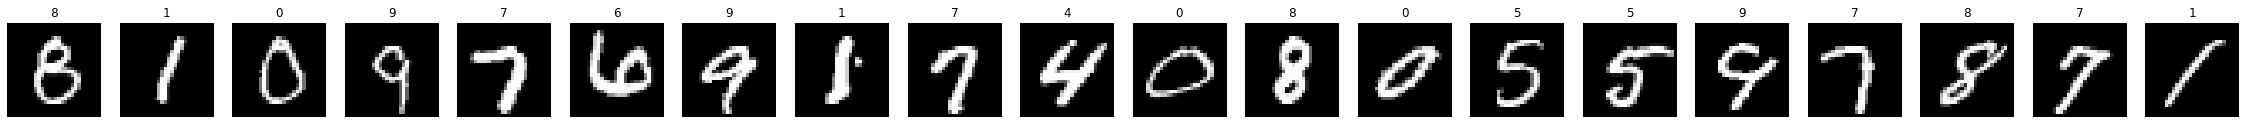

In [8]:
indices = [800, 3433, 3496, 3592, 4322, 4395, 4706, 6101, 6223, 6715, 7190, 7302, 7491, 7715, 8149, 8267, 8608, 9197, 9721, 9795]
images = x_test[indices]
fig, ax = plt.subplots(1, len(images), figsize=(len(images) * 2, 2))
for i, idx in enumerate(indices):
    ax[i].set_axis_off()
    ax[i].title.set_text(str(np.argmax(y_test[idx])))
    ax[i].imshow(np.reshape(images[i], (28, 28)), cmap='gray')
plt.show()

### 2. Create a fuzzer
ADAPT offers various modules (e.g. coverage metrics and neuron selection strategies) that can be used to compose a fuzzer. First thing to do is wrapping Keras model, since all modules in ADAPT uses a Keras model wrapped with the ```adapt.Network``` class.

In [9]:
from adapt import Network

In [10]:
network = Network(model)

Create a neuron coverage with 0.5 as threshold.

In [11]:
from adapt.metric import NC

In [12]:
metric = NC(0.5)

Create an adaptive and parameterized neuron selection strategy introduced in the following paper:

    Effective White-Box Testing of Deep Neural Networks with Adaptive Neuron-Selection Strategy
    
Note that the selection strategies and the fuzzers are created for each indivisual input.

In [13]:
from adapt.fuzzer import WhiteBoxFuzzer
from adapt.strategy import AdaptiveParameterizedStrategy

In [14]:
fuzzers_adapt = []
for image in images:
    strategy = AdaptiveParameterizedStrategy(network)
    fuzzer = WhiteBoxFuzzer(network, image, metric, strategy)
    fuzzers_adapt.append(fuzzer)

For comparision, fuzzers with random strategy, which selects neurons randomly, are used.

In [15]:
from adapt.strategy import RandomStrategy

In [16]:
fuzzers_rand = []
for image in images:
    strategy = RandomStrategy(network)
    fuzzer = WhiteBoxFuzzer(network, image, metric, strategy)
    fuzzers_rand.append(fuzzer)

### 3. Start testing
The given inputs are tested for 1 minute (20 minutes in total for one strategy), and only keep the generated inputs with minimum distances.

In [17]:
from datetime import datetime

In [18]:
print('Fuzzing with adaptive parameterized strategy started at {}.'.format(datetime.now()))
archives_adapt = [fuzzer.start(minutes=1, append='min_dist') for fuzzer in fuzzers_adapt]
print('Done')

Fuzzing with adaptive parameterized strategy started at 2020-07-01 11:45:12.428189.
Done


In [19]:
print('Fuzzing with random strategy started at {}.'.format(datetime.now()))
archives_rand = [fuzzer.start(minutes=1, append='min_dist') for fuzzer in fuzzers_rand]
print('Done')

Fuzzing with random strategy started at 2020-07-01 12:05:12.834440.
Done


### 4. Testing result
Here is the coverage graph.

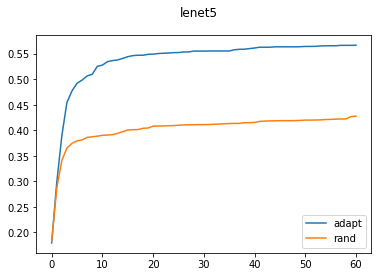

In [20]:
times = list(range(61))
coverages = []
for archive in archives_adapt:
    current_t = 0
    coverage = []
    for t, cov in archive.timestamp:
        if t > current_t:
            coverage.append(cov)
            current_t += 1
    coverages.append(coverage)
coverages = np.mean(coverages, axis=0)
plt.plot(times, coverages, label='adapt')
coverages = []
for archive in archives_rand:
    current_t = 0
    coverage = []
    for t, cov in archive.timestamp:
        if t > current_t:
            coverage.append(cov)
            current_t += 1
    coverages.append(coverage)
coverages = np.mean(coverages, axis=0)
plt.plot(times, coverages, label='rand')
plt.suptitle('lenet5')
plt.legend()
plt.show()

Archive classes stores all the testing result. You can easily see the testing result by following command.

In [21]:
archives_adapt[0].summary()

----------
Total inputs: 3590
  Average distance: 0.10337266325950623
Total adversarials: 761
  Average distance: 0.19320125877857208
Coverage
  Original: 0.20155038759689922
  Achieved: 0.6356589147286822
----------
Original label: 8
  Count: 2829
  Average distance: 0.07920879870653152
----------
Label: 5
  Count: 110
  Average distance: 0.20951449871063232
----------
Label: 0
  Count: 101
  Average distance: 0.2089652419090271
----------
Label: 2
  Count: 4
  Average distance: 0.23208466172218323
----------
Label: 7
  Count: 11
  Average distance: 0.37111905217170715
----------
Label: 4
  Count: 6
  Average distance: 0.4053909480571747
----------
Label: 6
  Count: 302
  Average distance: 0.15730032324790955
----------
Label: 3
  Count: 220
  Average distance: 0.21198512613773346
----------
Label: 9
  Count: 7
  Average distance: 0.18423578143119812
----------


Plus, the following is a visualization of some generated images.

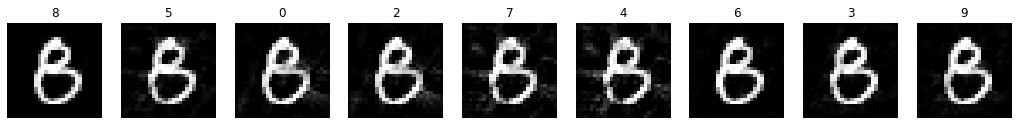

In [22]:
fig, ax = plt.subplots(1, len(archives_adapt[0].found_labels), figsize=(len(archives_adapt[0].found_labels) * 2, 2))
for i, label in enumerate(archives_adapt[0].found_labels.keys()):
    ax[i].set_axis_off()
    ax[i].title.set_text(str(label))
    ax[i].imshow(np.reshape(archives_adapt[0].inputs[label][0], (28, 28)).clip(0, 1), cmap='gray')
plt.show()